<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/kalman/Kalman_Filters_for_Nifty_ema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b
!pip install ffn

In [98]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
import ffn
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

[*********************100%***********************]  1 of 1 completed


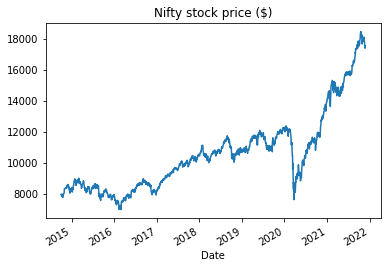

In [99]:
nifty_df = yf.download('^nsei',start='2014-10-01') # 2018
nifty_df['Adj Close'].plot(title='Nifty stock price ($)');


In [100]:
#nifty_df = yf.download('sbin.ns',start='2014-01-01',progress=False)


In [101]:
df = nifty_df[['Adj Close']]


mean 16099.378117582548


Text(0.5, 0, 'Days')

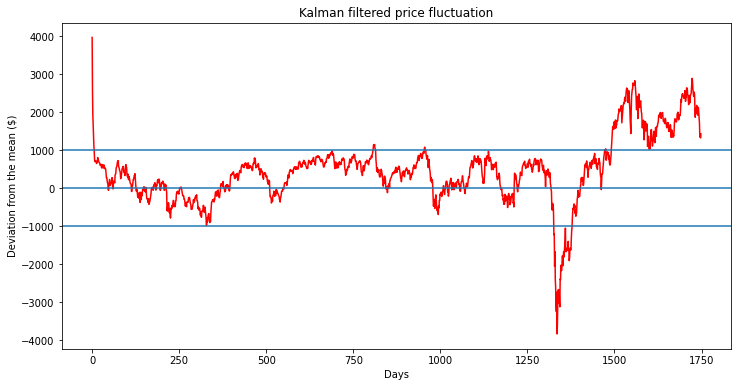

In [102]:
f = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance = 1,
                  transition_covariance = 0.0001)
mean, cov = f.filter(df['Adj Close'].values)
mean, std = mean.squeeze(), np.std(cov.squeeze())
print(f'mean {mean[-1]}')

plt.figure(figsize=(12,6))
plt.plot(df['Adj Close'].values - mean, 'red', lw=1.5)

plt.axhline(y=0)
plt.axhline(y=1000)
plt.axhline(y=-1000)
plt.title("Kalman filtered price fluctuation")
plt.ylabel("Deviation from the mean ($)")
plt.xlabel("Days")

In [103]:
nifty =pd.DataFrame({'Date': nifty_df.index,'Close':df['Adj Close'].values - mean})


In [104]:
nifty['30 Day MA'] = nifty['Close'].rolling(window=20).mean()
# set .std(ddof=0) for population std instead of sample
nifty['30 Day STD'] = nifty['Close'].rolling(window=20).std() 
nifty['Upper Band'] = nifty['30 Day MA'] + (nifty['30 Day STD'] *0.5)
nifty['Lower Band'] = nifty['30 Day MA'] - (nifty['30 Day STD'] *0.5)

nifty.ta.macd(fast=26,slow=50,signal=18, append=True)

print()

In [105]:
nifty=nifty.set_index('date')

In [106]:
nifty.tail(2)

,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_26_50_18,MACDh_26_50_18,MACDs_26_50_18
date,,,,,,,,
2021-11-24,1330.113406,1989.452083,330.408227,2154.656197,1824.247970,-107.550599,-112.485817,4.935218
2021-11-25,1436.871882,1940.492373,336.360289,2108.672517,1772.312228,-123.038614,-114.502903,-8.535712


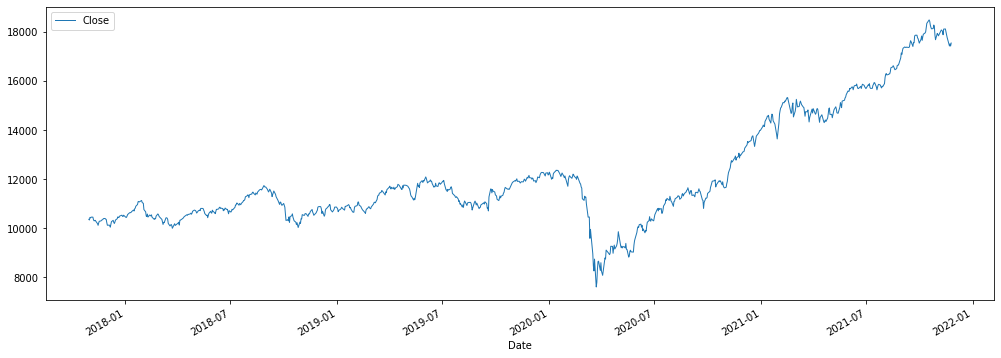

In [107]:
nifty_df[['Close']][-1000:].plot(figsize=(17,6),linewidth=1);

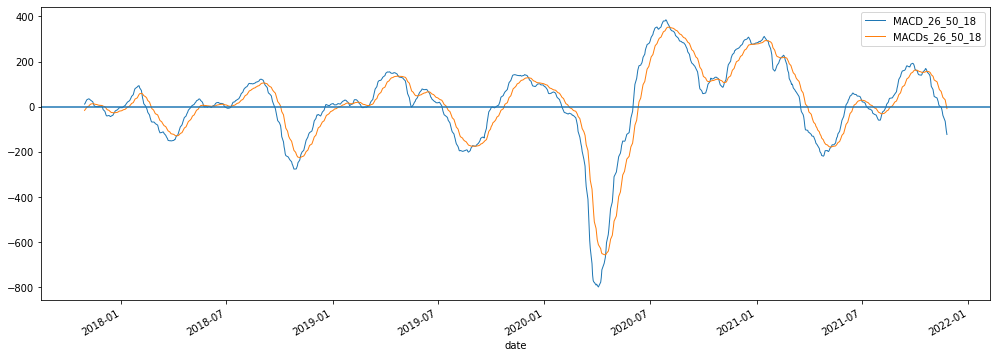

In [108]:
nifty[['MACD_26_50_18','MACDs_26_50_18']][-1000:].plot(figsize=(17,6),linewidth=1);
plt.axhline(y=0);

In [109]:
nifty['slope']=abs(nifty['MACD_26_50_18'].diff(5))
nifty['slope']=np.where(nifty['slope']<=10,0,nifty['slope'])
nifty['slope_s']=abs(nifty['MACDs_26_50_18'].diff(5))
nifty['slope_s']=np.where(nifty['slope_s']<=10,0,nifty['slope_s'])

In [110]:
l=-len(nifty)

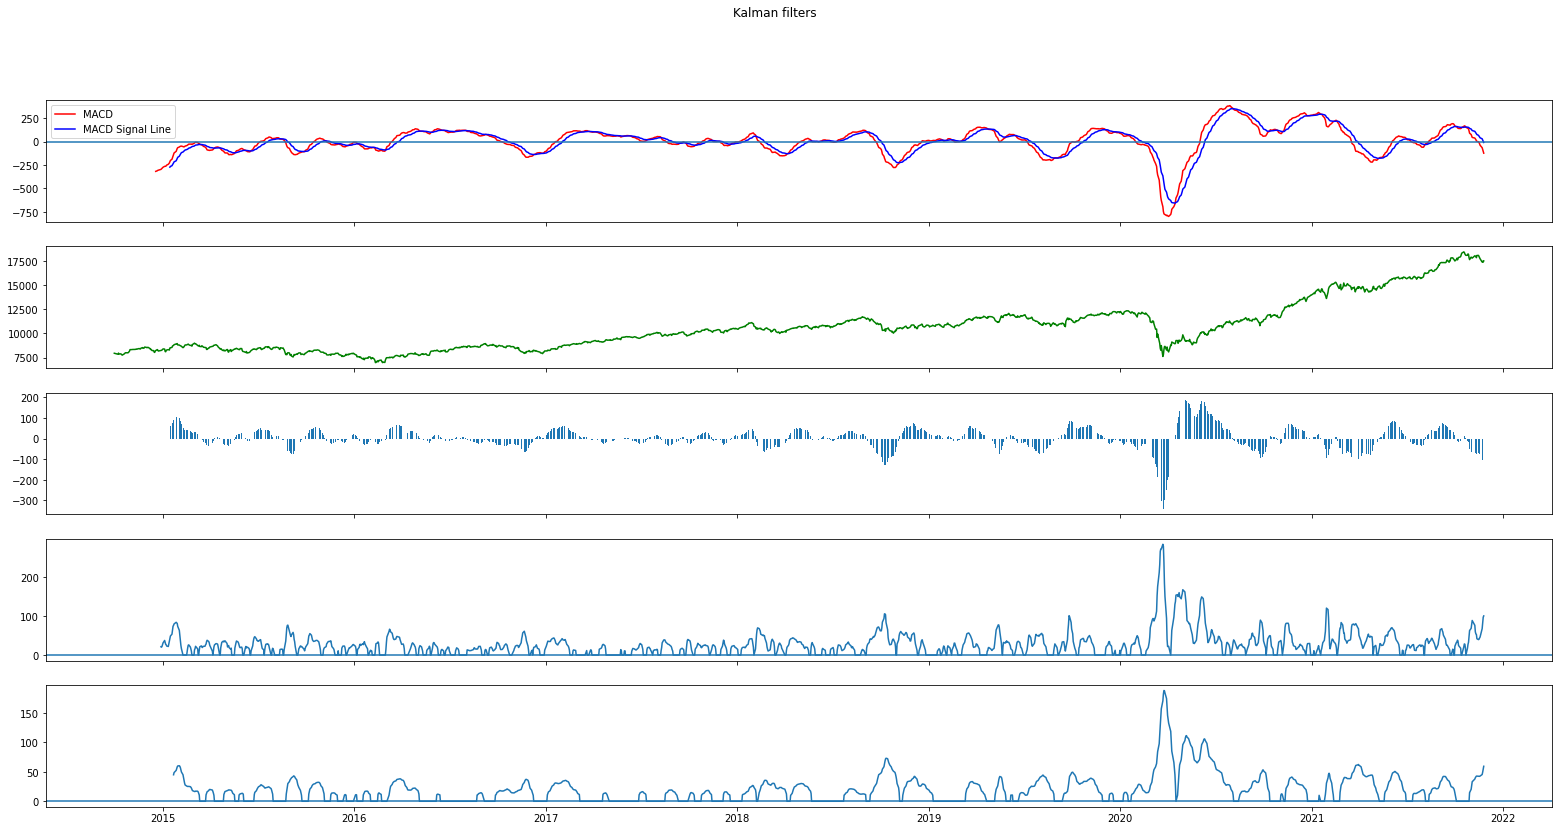

In [111]:
fig, ax = plt.subplots(5,1,figsize=(27,13),linewidth=1,sharex=True)
ax[0].plot(nifty.loc[:, :].index[l:], nifty.loc[:, 'MACD_26_50_18'][l:],'r', label='MACD')
ax[0].plot(nifty.loc[:, :].index[l:], nifty.loc[:, 'MACDs_26_50_18'][l:],'b', label='MACD Signal Line')
ax[2].bar(nifty.loc[:, :].index[l:], nifty.loc[:, 'MACDh_26_50_18'][l:], label='MACD Signal Line')
ax[1].plot(nifty_df.loc[:, :].index[l:], nifty_df.loc[:, 'Close'][l:],'g', label='NH moving avg 50 days')
ax[3].plot(nifty.iloc[:, :].index[l:], nifty.loc[:, 'slope'][l:], label='Slope')
ax[4].plot(nifty.iloc[:, :].index[l:], nifty.loc[:, 'slope_s'][l:], label='Slope')
plt.suptitle('Kalman filters')
ax[0].axhline(y=0)
ax[3].axhline(y=0)
ax[4].axhline(y=0)
ax[0].legend(loc='upper left')
plt.show()


In [112]:
nifty.tail(1)

,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_26_50_18,MACDh_26_50_18,MACDs_26_50_18,slope,slope_s
date,,,,,,,,,,
2021-11-25,1436.871882,1940.492373,336.360289,2108.672517,1772.312228,-123.038614,-114.502903,-8.535712,100.865027,59.455657


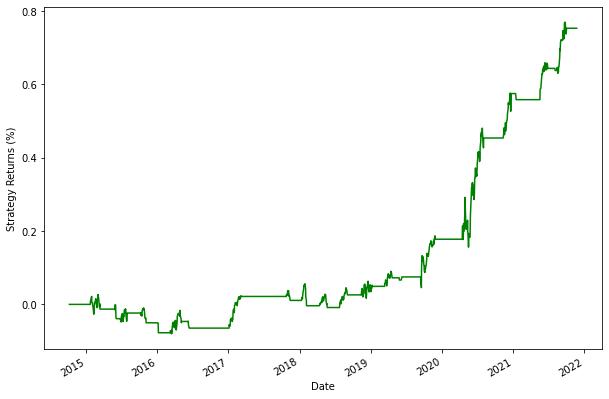

sharpe ratio :  0.035676855548355015
sortino ratio :  0.3348026732278146


In [113]:
nifty['sig']=np.where(nifty['MACDh_26_50_18']>0,1,-1)
nifty['sigs']=np.where(nifty['slope_s']>0,1,-1)
nifty['sigl']=nifty['sig']+nifty['sigs']
nifty['signals']=np.where(nifty['sigl']==2,1,0)
#nifty['signals']=np.where(nifty['sigl']==,1,nifty.signals)
# Calculate daily returns
nifty['Return'] = nifty_df.Close.pct_change()
 
# Calculate strategy returns
nifty['Strategy_F'] = nifty.Return * nifty.signals.shift(1)

# Calculate geometric returns
geometric_returns = ((nifty.Strategy_F+1).cumprod()-1)
#np.sum(np.log(data/data.shift())*portfolio, axis=1)
# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
volatility = geometric_returns.std() * np.sqrt(252)
sharpe_ratio = (geometric_returns.mean() - 0.05/252) / volatility 
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()
print('sharpe ratio : ' ,sharpe_ratio)
std_neg = geometric_returns[geometric_returns<0].std()*np.sqrt(252)
sortino_ratio=(geometric_returns.mean() - 0.05/252)/std_neg
print('sortino ratio : ' , sortino_ratio) 

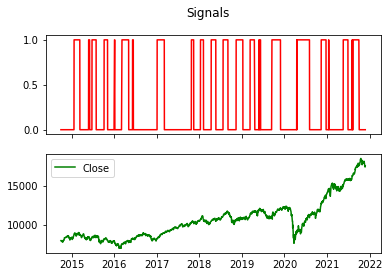

In [114]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'signals'],'r', label='Signals')
ax[1].plot(df.loc[:, :].index, df.loc[:, 'Adj Close'],'g', label='Close')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[1].legend()
plt.show()


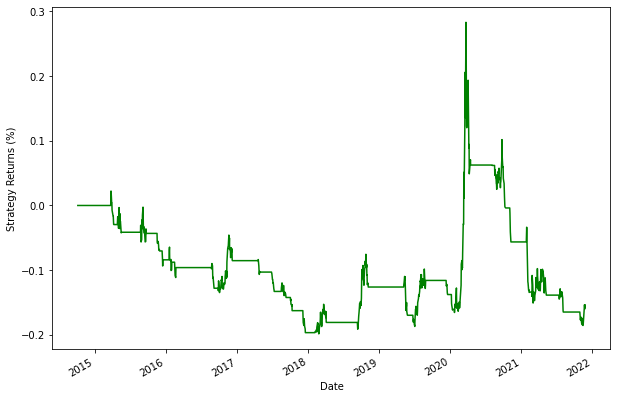

sharpe ratio :  -0.08238195458731393
sortino ratio :  -0.12754673708359243


In [121]:
nifty['sig_s']=np.where(nifty['MACDh_26_50_18']<0,-1,1)
nifty['sigs_s']=np.where(nifty['slope_s']>0,-1,1)
nifty['sigl_s']=nifty['sig_s']+nifty['sigs_s']
nifty['signals_s']=np.where(nifty['sigl_s']==-2,-1,0)
#nifty['signals']=np.where(nifty['sigl']==,1,nifty.signals)
# Calculate daily returns
nifty['Return'] = nifty_df.Close.pct_change()
 
# Calculate strategy returns
nifty['Strategy_F'] = nifty.Return * nifty.signals_s.shift(1)

# Calculate geometric returns
geometric_returns = ((nifty.Strategy_F+1).cumprod()-1)
#np.sum(np.log(data/data.shift())*portfolio, axis=1)
# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
volatility = geometric_returns.std() * np.sqrt(252)
sharpe_ratio = (geometric_returns.mean() - 0.05/252) / volatility 
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()
print('sharpe ratio : ' ,sharpe_ratio)
std_neg = geometric_returns[geometric_returns<0].std()*np.sqrt(252)
sortino_ratio=(geometric_returns.mean() - 0.05/252)/std_neg
print('sortino ratio : ' , sortino_ratio) 

In [122]:
stats = geometric_returns.calc_stats()  # use .calc_stats() on a series to invoke ffn.
stats.display()

Stats for Strategy_F from 2014-10-01 00:00:00 - 2021-11-25 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return    Sharpe    CAGR    Max Drawdown
--------------  --------  ------  --------------
-               -         inf%    -993.50%

Annualized Returns:
mtd     3m      6m      ytd      1y       3y     5y      10y    incep.
------  ------  ------  -------  -------  -----  ------  -----  --------
-3.28%  -3.28%  14.98%  182.72%  182.72%  8.12%  18.55%  -      inf%

Periodic:
        daily     monthly    yearly
------  --------  ---------  --------
sharpe  -         -          -
mean    inf%      inf%       -inf%
vol     -         -          -
skew    -         -          -
kurt    -         -          -
best    inf%      inf%       182.72%
worst   -291.19%  -545.50%   -inf%

Drawdowns:
max       avg         # days
--------  --------  --------
-993.50%  -254.25%     519.2

Misc:
---------------  -------
avg. up month    inf%
avg. down month  -23.58%
up year %       

In [123]:
stats.stats

start                    2014-10-01 00:00:00
end                      2021-11-25 00:00:00
rf                                         0
total_return                             NaN
cagr                                     inf
max_drawdown                        -9.93502
calmar                                   inf
mtd                               -0.0327868
three_month                       -0.0327868
six_month                           0.149763
ytd                                  1.82718
one_year                             1.82718
three_year                         0.0812399
five_year                           0.185529
ten_year                                 NaN
incep                                    inf
daily_sharpe                             NaN
daily_sortino                            inf
daily_mean                               inf
daily_vol                                NaN
daily_skew                               NaN
daily_kurt                               NaN
best_day  

In [118]:
stats.drawdown_details['drawdown'].plot();

TypeError: ignored

In [ ]:
stats.display_monthly_returns()